## AA-ICP: Iterative Closest Point with Anderson Acceleration

Main idea:
 * ICP uses iterative process, each iteration returns a transformation.
 * Using AA on these transformations may improve convergence.
 * ICP is considered a blackbox algorithm.

Reading some 3D model:

In [1]:
import os
import sys
import torch
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
%matplotlib inline


# Install pytorch3d
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip3 install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.transforms import random_rotation
from pytorch3d.ops import iterative_closest_point
from IPython.display import clear_output
from pytorch3d import loss

import matplotlib.pyplot as plt
import numpy
from functools import partial
import scipy
from scipy.optimize import root

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

# Set the device
#if torch.cuda.is_available():
#    device = torch.device("cuda:0")
#else:
#    device = torch.device("cpu")

# Download models
#!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
# Visualize model
def plot_pointcloud(meshes, title=""):
    # Sample points uniformly from the surface of the mesh.  
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    limits = [(0,0),(0,0),(0,0)]
    for name, mesh in meshes.items():
        points = sample_points_from_meshes(mesh, 5000)
        x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
        ax.scatter3D(x, z, -y, label = name)
        for i, v in enumerate((x,y,z)):
            limits[i] = (min(min(v).item(), limits[i][0]), max(max(v).item(), limits[i][1]))
            #print(limits)
    ax.set_title(title)
    #ax.view_init(190, -10)
    #ax.set_axis_off()
    #ax.set_xlim(2*limits[0][0], 2*limits[0][1])
    #ax.set_zlim(2*limits[1][0], 2*limits[1][1])
    #ax.set_ylim(2*limits[2][0], 2*limits[2][1])
    
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)

    plt.legend()
    plt.show()

In [3]:
device = torch.device("cpu")

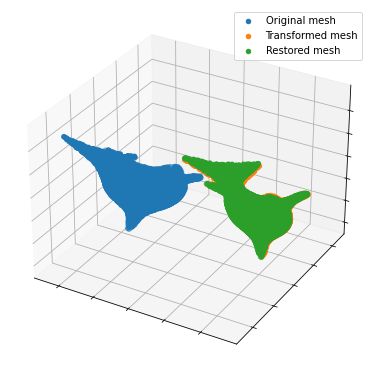

In [26]:
# Load mesh
obj = os.path.join('dolphin.obj')

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)
mesh = Meshes(verts=[verts], faces=[faces_idx])

# Do random transformation - shift and rotation.
#  Rotation might need to be small.
#  Store transformation for future comparison

R = pytorch3d.transforms.euler_angles_to_matrix(torch.tensor((numpy.random.rand(3)-0.5)/2).float(),convention = "XYZ")
T = torch.randn(verts.shape[1], device=device)/2
verts_transformed = verts @ R + T

mesh_transformed = Meshes(verts=[verts_transformed], faces=[faces_idx])

solution = iterative_closest_point(verts[None, :], verts_transformed[None, :], max_iterations=int(1e6), )
#solution.rmse, solution.converged

# Restore transformations
R_restored, T_restored = solution.RTs.R[0], solution.RTs.T[0]
mesh_restored = Meshes(verts=[mesh.verts_list()[0]@R_restored + T_restored], faces=mesh.faces_list())

plot_pointcloud({"Original mesh": mesh, "Transformed mesh":mesh_transformed, "Restored mesh":mesh_restored})

KeyboardInterrupt: 

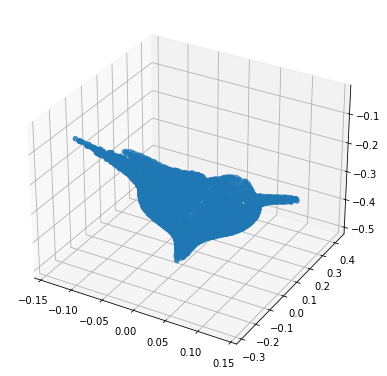

In [27]:
for i, t in enumerate(solution.t_history):
    R_restored, T_restored = t.R[0], t.T[0]
    mesh_restored = Meshes(verts=[mesh.verts_list()[0]@R_restored + T_restored], faces=mesh.faces_list())
    plot_pointcloud({"Original mesh": mesh, "Transformed mesh":mesh_transformed, "Restored mesh":mesh_restored}, f"{i}-th iteration")
    clear_output(True)

Now lets compare basic ICP algorithm with improved one:

In [28]:
from scipy.spatial.transform import Rotation

def ICP_iteration(*args, **kwargs):
    return iterative_closest_point(max_iterations=int(1),*args, **kwargs)

vector_types = ["flatten", "euler"]

def transformation_to_vector(R, T, vector_type = "flatten"):
    formats = {
        "flatten" : (lambda R, T: numpy.concatenate([R.flatten() , T.flatten()])),
        "euler" : (lambda R, T: numpy.concatenate([(scipy.spatial.transform.Rotation.from_matrix(R).as_euler('xyz')).flatten() , T.flatten()])),
    }
    return formats[vector_type](R, T)

def vector_to_transformation(vector, vector_type = "flatten"):
    formats = {
        "flatten" : (lambda v: (v[:9].reshape((3,3)), v[9:].reshape((3)))),
        "euler" : (lambda v: (scipy.spatial.transform.Rotation.from_euler('xyz',v[:3]).as_matrix() , v[3:].reshape((3)))),
    }
    return formats[vector_type](vector)

In [35]:
#Implemented in .py files
from anderson import anderson
from picard import picard

maxiter = 35
iterative_methods = {
    "Picard iterations" : picard,
    "Anderson" : partial(anderson, memory=5),
    "Anderson, limited alpha" : partial(anderson, memory=5, alpha_limit=10.0),
    "Anderson, positive alpha0" : partial(anderson, memory=5, alpha0_min=0.000),
    "Anderson, positive alpha0, limited alpha" : partial(anderson, memory=5, alpha_limit=10.0, alpha0_min=0.000),
#    "Scipy's AA, default" : (lambda F, x0, maxiter, *args, **kwargs: root((lambda x: F(x) - x), x0, method="anderson", options = {"nit": maxiter}, *args, **kwargs).x),
    "Scipy's AA, M=5" : (lambda F, x0, maxiter, *args, **kwargs: root((lambda x: F(x) - x), x0, method="anderson", options = {"nit": maxiter, "jac_options":{"M":5}}, *args, **kwargs).x),
#    "Scipy's AA, M=10, line_search=None" : (lambda F, x0, maxiter: root((lambda x: F(x) - x), x0, method="anderson", options = {"nit": maxiter, "line_search": None, "jac_options":{"M":10}}).x),
#    "Scipy's AA, M=10, line_search=None, w0" : (lambda F, x0, maxiter: root((lambda x: F(x) - x), x0, method="anderson", options = {"nit": maxiter, "line_search": None, "jac_options":{"M":10,"w0":0.0001}}).x),
}

flatten Picard iterations : 0.0002926
euler Picard iterations : 0.0002927
flatten Anderson : 0.0004514
euler Anderson : 0.000568
flatten Anderson, limited alpha : 0.0016263
euler Anderson, limited alpha : 0.0001063
flatten Anderson, positive alpha0 : 0.0004514
	Same error as for flatten Anderson
euler Anderson, positive alpha0 : 0.000568
	Same error as for euler Anderson
flatten Anderson, positive alpha0, limited alpha : 0.0016263
	Same error as for flatten Anderson, limited alpha
euler Anderson, positive alpha0, limited alpha : 0.0001063
	Same error as for euler Anderson, limited alpha
flatten Scipy's AA, M=5 : 0.0008333
euler Scipy's AA, M=5 : 0.0016111


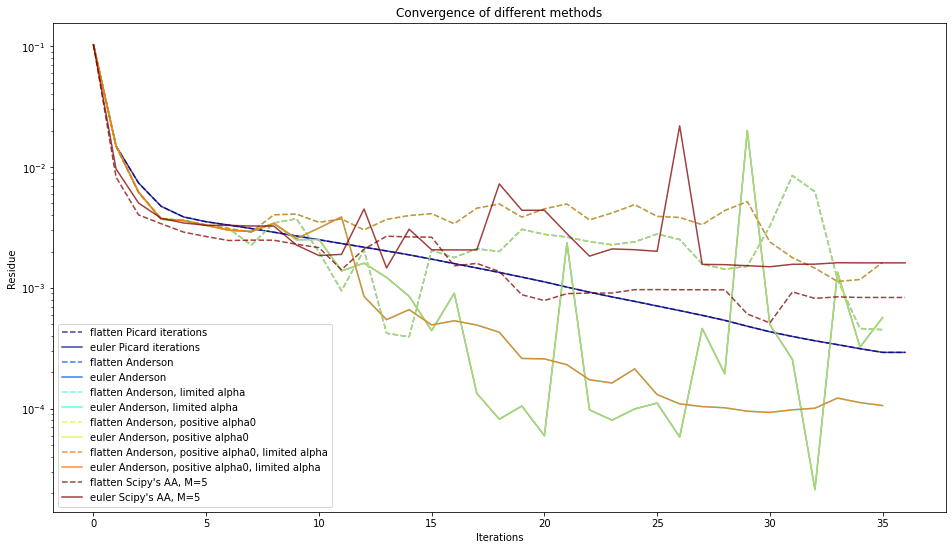

In [36]:
# Function
def F(x, vector_type = "flatten"):
    R,T = vector_to_transformation(x, vector_type)
    t = pytorch3d.ops.points_alignment.SimilarityTransform( \
      R = torch.from_numpy(R).float()[None, ...], \
      T = torch.from_numpy(T).float()[None, ...], \
      s = torch.ones(1))
    solution = iterative_closest_point(verts[None, :], verts_transformed[None, :], init_transform = t, max_iterations=int(1))
    return transformation_to_vector(solution.RTs.R[0].numpy(), solution.RTs.T[0].numpy(), vector_type)
# Starting point
x0 = (numpy.eye(3), numpy.zeros(3))
# How to calculate residual for the solution
def residual(x, verts, verts_transformed, vector_type = "flatten"):
    R,T = vector_to_transformation(x, vector_type)
    #return torch.norm(verts_transformed - (verts@R+T)) / verts.size()[0]
    return pytorch3d.loss.chamfer_distance(verts_transformed[None, ...].float(),(verts@R+T)[None, ...].float())[0]
    

plt.rcParams["figure.figsize"] = [16,9]

colors = plt.cm.jet(numpy.linspace(0,1,len(iterative_methods)))
lines = ["--","-","-.",":"]
res = {}
residual = partial(residual, verts= verts, verts_transformed=verts_transformed)
for nm, color in zip(iterative_methods.items(), colors):
    name, method = nm
    for v_type, line in zip(vector_types, lines):
        F_v = partial(F, vector_type = v_type)
        x0_v = transformation_to_vector(*x0, vector_type = v_type)
        xs = [residual(x0_v, vector_type = v_type)]
        callback = (lambda x,r,xs=xs : xs.append(residual(x, vector_type = v_type)))
        xs += [residual(method(F_v, x0_v, maxiter = maxiter, callback = callback), vector_type = v_type)]
        plt.plot(xs, label = v_type + " " + name, linestyle = line, color = color, alpha = 0.75)
        error = round(xs[-1].item(), 7)
        print("%s %s : %s" % (v_type, name, error))
        if error in res:
            print("\tSame error as for %s" % res[error])
        else:
            res[error] = "%s %s" % (v_type, name)
plt.title("Convergence of different methods")
plt.xlabel("Iterations")
plt.ylabel("Residue")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

AA-ICP performs a jump to nearly optimal solution after 15 iterations.

Following euristics should be used:
  * Rotational matrix should be transformed to Euler angles, not simply flattened
  * Limitations on $\alpha_i$ are crucial for avoiding incorrect jumps
  * Limitation $\alpha_0 > 0$ does not affect convergence. 
  
Now, lets try do determine optimal $\alpha_l$ parameter and history length.

Picard : 0.0002927
Alpha=1.0 : 0.0002927
Alpha=2.0 : 0.000258
Alpha=3.0 : 0.000258
Alpha=4.0 : 0.0002306
Alpha=5.0 : 0.0002331
Alpha=6.0 : 0.0001903
Alpha=7.0 : 0.0010026
Alpha=8.0 : 8.46e-05
Alpha=9.0 : 0.0001063
Alpha=10.0 : 0.0001063
Alpha=11.0 : 8.45e-05
Alpha=12.0 : 0.0002268
Alpha=13.0 : 0.0002268
Alpha=14.0 : 0.0002268
Alpha=15.0 : 0.0002268
Alpha=16.0 : 0.0002268
Alpha=17.0 : 0.0002268
Alpha=18.0 : 0.0002268
Alpha=19.0 : 0.000568
Alpha=20.0 : 0.000568
Anderson : 0.000568


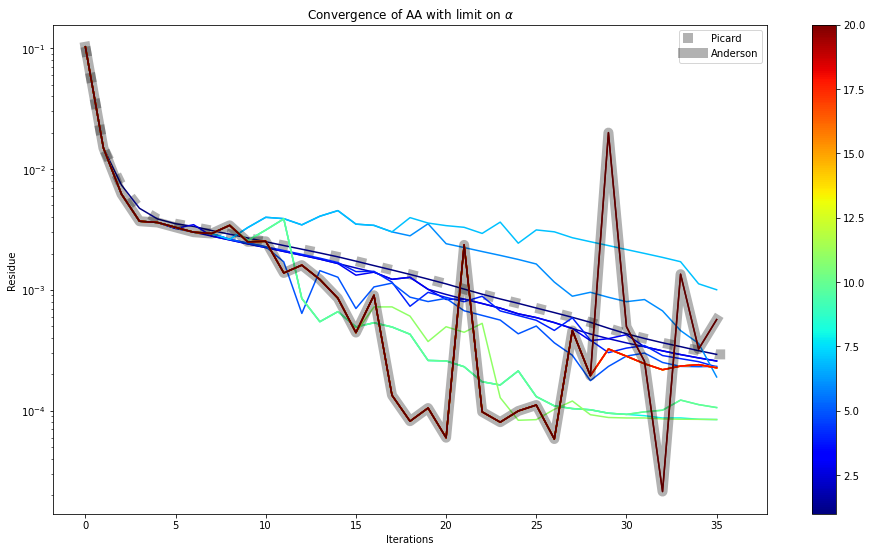

In [34]:
residual = partial(residual, verts= verts, verts_transformed=verts_transformed)
v_type = "euler"
alphas_min, alphas_max = 1.0, 20.0
alphas = numpy.linspace(alphas_min, alphas_max, int(alphas_max - alphas_min) + 1)

F_v = partial(F, vector_type = v_type)
x0_v = transformation_to_vector(*x0, vector_type = v_type)

# Picard as baseline
method = picard
xs = [residual(x0_v, vector_type = v_type)]
callback = (lambda x,r,xs=xs : xs.append(residual(x, vector_type = v_type)))
xs += [residual(method(F_v, x0_v, maxiter = maxiter, callback = callback), vector_type = v_type)]
plt.plot(xs, label = "Picard", color = "black", linestyle=":", linewidth = 10, alpha = 0.3)
print("Picard : %s" % (round(xs[-1].item(), 7)))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=alphas_min, vmax=alphas_max)
colormap = cm.jet

for alpha in alphas:
    method = partial(anderson, memory = 5, alpha_limit=alpha, alpha0_min=0.000)
    xs = [residual(x0_v, vector_type = v_type)]
    callback = (lambda x,r,xs=xs : xs.append(residual(x, vector_type = v_type)))
    xs += [residual(method(F_v, x0_v, maxiter = maxiter, callback = callback), vector_type = v_type)]
    plt.plot(xs, color = colormap(normalize(alpha)))
    error = round(xs[-1].item(), 7)
    print("Alpha=%s : %s" % (alpha, error))
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(alphas)
plt.colorbar(scalarmappaple)

    
# Anderson as other baseline
method = partial(anderson, memory = 5, alpha0_min=0.000)
xs = [residual(x0_v, vector_type = v_type)]
callback = (lambda x,r,xs=xs : xs.append(residual(x, vector_type = v_type)))
xs += [residual(method(F_v, x0_v, maxiter = 35, callback = callback), vector_type = v_type)]
plt.plot(xs, label = "Anderson" % alpha, color = "black", linewidth = 10, alpha = 0.3)
print("Anderson : %s" % (round(xs[-1].item(), 7)))


plt.title(r"Convergence of AA with limit on $\alpha$")
plt.xlabel("Iterations")
plt.ylabel("Residue")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

As can be seen, too strict limitaion on $\alpha$ (low $\alpha_l$) forces Picard iterations, while, on the other hand, too big $\alpha_l$ will not affect convergence. As in original paper, values around 10 seem to be enough.

Picard : 0.0002927
Memory=2 : 0.0007403
Memory=3 : 8.47e-05
Memory=4 : 0.0001037
Memory=5 : 0.0001063


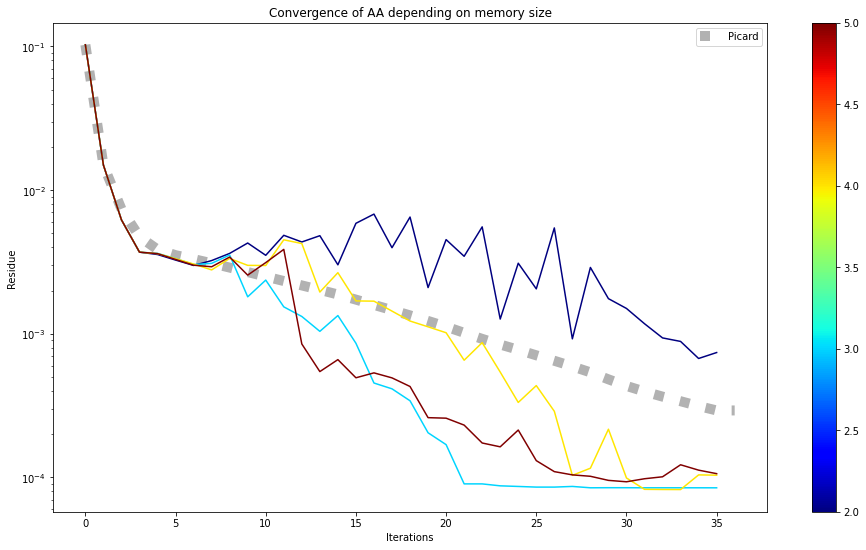

In [33]:
residual = partial(residual, verts= verts, verts_transformed=verts_transformed)
v_type = "euler"
memories = range(2, 6)

F_v = partial(F, vector_type = v_type)
x0_v = transformation_to_vector(*x0, vector_type = v_type)

# Picard as baseline
method = picard
xs = [residual(x0_v, vector_type = v_type)]
callback = (lambda x,r,xs=xs : xs.append(residual(x, vector_type = v_type)))
xs += [residual(method(F_v, x0_v, maxiter = maxiter, callback = callback), vector_type = v_type)]
plt.plot(xs, label = "Picard", color = "black", linestyle=":", linewidth = 10, alpha = 0.3)
print("Picard : %s" % (round(xs[-1].item(), 7)))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=min(memories), vmax=max(memories))
colormap = cm.jet

for mem in memories:
    method = partial(anderson, memory=mem, alpha_limit=10.0, alpha0_min=0.000)
    xs = [residual(x0_v, vector_type = v_type)]
    callback = (lambda x,r,xs=xs : xs.append(residual(x, vector_type = v_type)))
    xs += [residual(method(F_v, x0_v, maxiter = maxiter, callback = callback), vector_type = v_type)]
    plt.plot(xs, color = colormap(normalize(mem)))
    error = round(xs[-1].item(), 7)
    print("Memory=%s : %s" % (mem, error))
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(memories)
plt.colorbar(scalarmappaple)

    
plt.title("Convergence of AA depending on memory size")
plt.xlabel("Iterations")
plt.ylabel("Residue")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

With history length of 1 Anderson performs just as Picard iterations.
Storing as much history as possible, up until the size of linearized transformation matrix. Storing more history is not practical, since optimization problem (least squares) inside Anderson algorithm becomes over-determined.